In [1]:
# Setup e imports
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from scrappers.understat import Understat
from viz.shot_xg import plot_shot_xg
from blog.get_match_ids import get_match_ids
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = "data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Setup complete')

Setup complete


In [2]:
# Configuración
PLAYER_NAME = "Etta Eyong"
TEAM_NAME_CURRENT = "Levante"
TEAM_NAME_PREVIOUS = "Villarreal"
LEAGUE = "ESP-La Liga"
SEASON = "25-26"
NUM_MATCHES_VILLARREAL = 3  # Primeras 3 jornadas con Villarreal
NUM_MATCHES_LEVANTE = 11    # Siguientes 11 con Levante
LOGO_PATH = "../caras/extras/Eyong.png"

print(f'Player: {PLAYER_NAME}')
print(f'Teams: {TEAM_NAME_PREVIOUS} (J1-3) + {TEAM_NAME_CURRENT} (J4-14)')
print(f'League: {LEAGUE}')
print(f'Season: {SEASON}')
print(f'Total matches: {NUM_MATCHES_VILLARREAL + NUM_MATCHES_LEVANTE}')

Player: Etta Eyong
Teams: Villarreal (J1-3) + Levante (J4-14)
League: ESP-La Liga
Season: 25-26
Total matches: 14


In [3]:
# Extraer match IDs de ambos equipos
print('Extrayendo IDs de partidos...')
print('=' * 70)

# Primeras 3 jornadas con Villarreal
print(f'\n1. Extrayendo partidos de {TEAM_NAME_PREVIOUS}')
villarreal_matches = get_match_ids(TEAM_NAME_PREVIOUS, LEAGUE, SEASON, verbose=False)
villarreal_matches = villarreal_matches.head(NUM_MATCHES_VILLARREAL)
print(f'   ✓ {len(villarreal_matches)} partidos de {TEAM_NAME_PREVIOUS} (J1-3)')

# Jornadas 4-14 con Levante (partidos del 3 al 13, índices 3:14)
print(f'\n2. Extrayendo partidos de {TEAM_NAME_CURRENT}')
levante_all = get_match_ids(TEAM_NAME_CURRENT, LEAGUE, SEASON, verbose=False)
levante_matches = levante_all.iloc[3:14]  # Desde J4 hasta J14
print(f'   ✓ {len(levante_matches)} partidos de {TEAM_NAME_CURRENT} (J4-14)')

# Combinar ambos
all_matches = pd.concat([villarreal_matches, levante_matches], ignore_index=True)
matches = all_matches.sort_values('date').reset_index(drop=True)

print(f'\n3. Total partidos combinados: {len(matches)}')
print('\nPartidos a analizar:')
print(matches[['date', 'home_team', 'away_team', 'understat_id']])

understat_ids = matches['understat_id'].dropna().astype(int).tolist()
print(f'\n✓ Understat IDs disponibles: {len(understat_ids)}/{len(matches)}')

Extrayendo IDs de partidos...

1. Extrayendo partidos de Villarreal


INFO     Retrieving calendar for ESP-La Liga 2526

INFO     [1/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [2/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [3/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [4/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [5/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [6/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [7/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [8/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [9/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [10/10] Retrieving fixtures for ESP-La Liga 2526

   ✓ 3 partidos de Villarreal (J1-3)

2. Extrayendo partidos de Levante


INFO     Retrieving calendar for ESP-La Liga 2526

INFO     [1/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [2/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [3/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [4/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [5/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [6/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [7/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [8/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [9/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [10/10] Retrieving fixtures for ESP-La Liga 2526

   ✓ 11 partidos de Levante (J4-14)

3. Total partidos combinados: 14

Partidos a analizar:
                  date        home_team       away_team  understat_id
0  2025-08-15 19:30:00       Villarreal     Real Oviedo         29159
1  2025-08-24 17:30:00       Villarreal          Girona         29173
2  2025-08-31 15:00:00       Celta Vigo      Villarreal         29185
3  2025-09-14 14:15:00          Levante      Real Betis         29191
4  2025-09-20 12:00:00           Girona         Levante         29202
5  2025-09-23 19:30:00          Levante     Real Madrid         29210
6  2025-09-27 12:00:00           Getafe         Levante         29222
7  2025-10-04 12:00:00      Real Oviedo         Levante         29236
8  2025-10-19 16:30:00          Levante  Rayo Vallecano         29243
9  2025-10-26 13:00:00         Mallorca         Levante         29257
10 2025-11-02 13:00:00          Levante      Celta Vigo         29265
11 2025-11-08 17:30:00  Atletico Madrid         Levante         2926

In [4]:
def transform_understat_to_shotmap(df):
    df_transformed = df.copy()
    df_transformed['x'] = df_transformed['location_x'] * 100
    df_transformed['y'] = df_transformed['location_y'] * 100
    df_transformed['is_goal'] = df_transformed['result'] == 'Goal'
    df_transformed['shot_body_part'] = df_transformed['body_part'].apply(
        lambda x: 'Head' if pd.isna(x) or x == 'Other' else x
    )
    return df_transformed

print('Helper function defined')

Helper function defined


In [5]:
us = Understat(leagues=LEAGUE, seasons='2025')

etta_shots = []

print('Extrayendo datos de Understat...')
print('=' * 70)

for i, (idx, row) in enumerate(matches.iterrows(), 1):
    match_id = row['understat_id']

    if pd.isna(match_id):
        print(f'[{i}/{len(matches)}] Sin ID Understat')
        continue

    try:
        shots = us.read_shot_events(match_id=int(match_id))
        shots_reset = shots.reset_index()

        player_shots = shots_reset[
            shots_reset['player'].str.contains('Eyong', case=False, na=False)
        ].copy()

        if not player_shots.empty:
            etta_shots.append(player_shots)
            goals = (player_shots['result'] == 'Goal').sum()
            xg_total = player_shots['xg'].sum()
            print(f'[{i}/{len(matches)}] Match {int(match_id)}: {len(player_shots)} shots | {goals} goals | xG: {xg_total:.2f}')
        else:
            print(f'[{i}/{len(matches)}] Match {int(match_id)}: 0 shots')

    except Exception as e:
        print(f'[{i}/{len(matches)}] Match {int(match_id)}: ERROR - {e}')

if etta_shots:
    df_etta = pd.concat(etta_shots, ignore_index=True)
    print('\n' + '=' * 70)
    print(f'Total shots de Etta Eyong: {len(df_etta)}')
    print(f'Goles: {(df_etta["result"] == "Goal").sum()}')
    print(f'xG total: {df_etta["xg"].sum():.2f}')
else:
    df_etta = pd.DataFrame()
    print('\n⚠ No se encontraron disparos de Etta Eyong')

Extrayendo datos de Understat...


[1/14] Match 29159: 2 shots | 1 goals | xG: 0.58
[2/14] Match 29173: 4 shots | 0 goals | xG: 0.85
[3/14] Match 29185: 1 shots | 0 goals | xG: 0.06
[4/14] Match 29191: 1 shots | 1 goals | xG: 0.69
[5/14] Match 29202: 2 shots | 1 goals | xG: 0.96
[6/14] Match 29210: 4 shots | 1 goals | xG: 1.07
[7/14] Match 29222: 4 shots | 0 goals | xG: 0.39
[8/14] Match 29236: 2 shots | 1 goals | xG: 0.88
[9/14] Match 29243: 2 shots | 0 goals | xG: 0.13
[10/14] Match 29257: 2 shots | 1 goals | xG: 0.88
[11/14] Match 29265: 4 shots | 0 goals | xG: 0.95
[12/14] Match 29269: 0 shots
[13/14] Match 29286: 1 shots | 0 goals | xG: 0.05
[14/14] Match 29295: 2 shots | 0 goals | xG: 0.32

Total shots de Etta Eyong: 31
Goles: 6
xG total: 7.82


In [6]:
if not df_etta.empty:
    df_etta_shotmap = transform_understat_to_shotmap(df_etta)

    csv_path = f'{OUTPUT_DIR}etta_eyong_shots.csv'
    df_etta_shotmap.to_csv(csv_path, index=False)

    print(f'Guardado: {csv_path}')
    print(f'Columnas: {list(df_etta_shotmap.columns)}')
else:
    print('No hay datos para transformar')

Guardado: data/etta_eyong_shots.csv
Columnas: ['league', 'season', 'game', 'team', 'player', 'league_id', 'season_id', 'game_id', 'date', 'shot_id', 'team_id', 'player_id', 'assist_player_id', 'assist_player', 'xg', 'location_x', 'location_y', 'minute', 'body_part', 'situation', 'result', 'x', 'y', 'is_goal', 'shot_body_part']


In [7]:
if not df_etta.empty:
    shots_count = len(df_etta)
    goals = (df_etta['result'] == 'Goal').sum()
    xg_total = df_etta['xg'].sum()
    performance = goals - xg_total

    print('=' * 70)
    print(f'ETTA EYONG - SHOT ANALYSIS')
    print(f'{TEAM_NAME_PREVIOUS} (J1-3) + {TEAM_NAME_CURRENT} (J4-14) | {LEAGUE} {SEASON}')
    print('=' * 70)
    print(f'Partidos analizados: {len(matches)}')
    print(f'Total shots: {shots_count}')
    print(f'Goles: {goals}')
    print(f'xG total: {xg_total:.2f}')
    print(f'Performance vs xG: {performance:+.2f} ({performance/xg_total*100:+.1f}%)')
    print(f'Conversión: {goals/shots_count*100:.1f}%')

ETTA EYONG - SHOT ANALYSIS
Villarreal (J1-3) + Levante (J4-14) | ESP-La Liga 25-26
Partidos analizados: 14
Total shots: 31
Goles: 6
xG total: 7.82
Performance vs xG: -1.82 (-23.3%)
Conversión: 19.4%


Saved: data/etta_eyong_shots.png


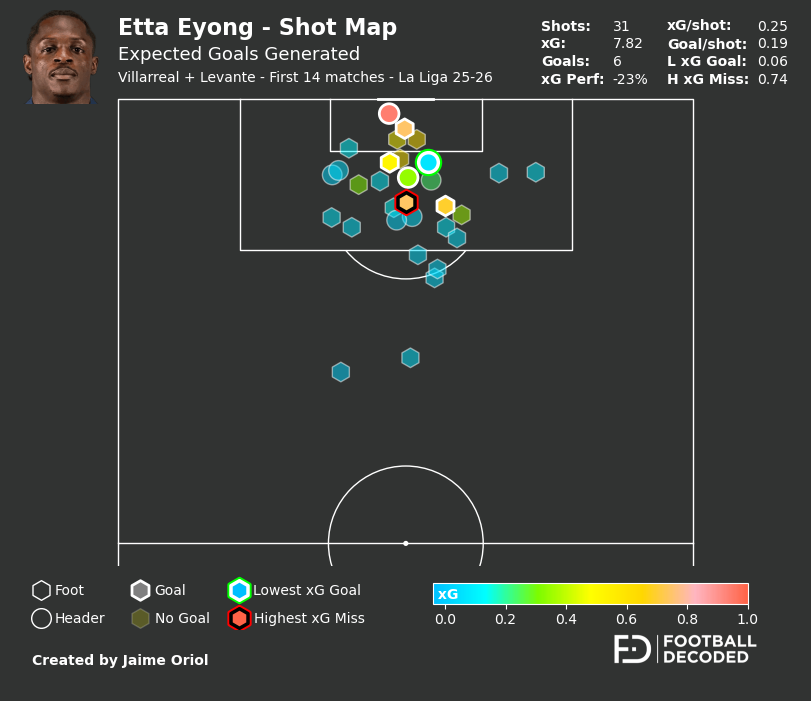

In [8]:
if not df_etta.empty:
    total_matches = NUM_MATCHES_VILLARREAL + NUM_MATCHES_LEVANTE
    
    fig = plot_shot_xg(
        csv_path=csv_path,
        filter_by='all',
        logo_path=LOGO_PATH,
        title_text=f'{PLAYER_NAME} - Shot Map',
        subtitle_text='Expected Goals Generated',
        subsubtitle_text=f'{TEAM_NAME_PREVIOUS} + {TEAM_NAME_CURRENT} - First {total_matches} matches - La Liga {SEASON}'
    )

    png_path = f'{OUTPUT_DIR}etta_eyong_shots.png'
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='#313332')

    print(f'Saved: {png_path}')
else:
    print('No se puede generar visualización sin datos')

In [9]:
print('=' * 70)
print('ARCHIVOS GENERADOS:')
print('=' * 70)
if not df_etta.empty:
    print(f'  {csv_path}')
    print(f'  {png_path}')
else:
    print('  Ninguno (no hay datos de disparos)')

ARCHIVOS GENERADOS:
  data/etta_eyong_shots.csv
  data/etta_eyong_shots.png
